# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

Мы научимся обрабатывать пропуски в данных для количественных (числовых) и категориальных признаков и масштабировать данные. Также мы научимся преобразовывать категориальные признаки в числовые.

### В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на масштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных

Используем данные из соревнования [House Prices: Advanced Regression Techniques.](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [3]:
# Будем использовать только обучающую выборку
data = pd.read_csv('data/QS World University Rankings 2025 new.csv', sep=",")

In [4]:
# размер набора данных
data.shape

(1503, 29)

In [5]:
# типы колонок
data.dtypes

INDEX              int64
rank display      object
rank display2     object
institution       object
location code     object
location          object
size              object
focus             object
research          object
status            object
ar score         float64
ar rank           object
er score         float64
er rank           object
fsr score        float64
fsr rank          object
cpf score        float64
cpf rank          object
ifr score        float64
ifr rank          object
isr score        float64
isr rank          object
irn score        float64
irn rank          object
ger score        float64
ger rank          object
SUS SCORE        float64
SUS RANK          object
Overall Score     object
dtype: object

In [6]:
# проверим есть ли пропущенные значения
data.isnull().sum()

INDEX              0
rank display       0
rank display2     21
institution        0
location code      0
location           0
size               0
focus              0
research           0
status            37
ar score           0
ar rank            0
er score           0
er rank            0
fsr score          0
fsr rank           0
cpf score          0
cpf rank           0
ifr score        100
ifr rank         100
isr score         58
isr rank          58
irn score          1
irn rank           1
ger score          0
ger rank           0
SUS SCORE         19
SUS RANK          19
Overall Score      0
dtype: int64

In [7]:
# Первые 5 строк датасета
data.head()

,INDEX,rank display,rank display2,institution,location code,location,size,focus,research,status,...,ifr rank,isr score,isr rank,irn score,irn rank,ger score,ger rank,SUS SCORE,SUS RANK,Overall Score
0,1,1,1,Massachusetts Institute of Technology (MIT),United States,Americas,M,CO,VH,B,...,100,86.8,143,96.0,58,100.0,8,99.0,15=,100
1,2,2,6,Imperial College London,United Kingdom,Europe,L,FC,VH,A,...,66,99.6,44,97.4,34,93.4,61,99.7,6,98.5
2,3,3,3,University of Oxford,United Kingdom,Europe,L,FC,VH,A,...,120,97.7,73,100.0,1,100.0,3,85.0,126,96.9
3,4,4,4,Harvard University,United States,Americas,L,FC,VH,B,...,269,69.0,215,99.6,5,100.0,1,84.4,130,96.8
4,5,5,2,University of Cambridge,United Kingdom,Europe,L,FC,VH,A,...,73,94.8,98,99.3,10,100.0,5,84.8,127=,96.7


In [8]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 1503


# Обработка пропусков в данных

## Простые стратегии - удаление или заполнение нулями

Удаление колонок, содержащих пустые значения
`res = data.dropna(axis=1, how='any')`

Удаление строк, содержащих пустые значения
`res = data.dropna(axis=0, how='any')`

[Документация](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

**Удаление может производиться для группы строк или колонок.**

In [9]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((1503, 29), (1503, 19))

In [12]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((1503, 29), (1348, 29))

In [14]:
data.head()

,INDEX,rank display,rank display2,institution,location code,location,size,focus,research,status,...,ifr rank,isr score,isr rank,irn score,irn rank,ger score,ger rank,SUS SCORE,SUS RANK,Overall Score
0,1,1,1,Massachusetts Institute of Technology (MIT),United States,Americas,M,CO,VH,B,...,100,86.8,143,96.0,58,100.0,8,99.0,15=,100
1,2,2,6,Imperial College London,United Kingdom,Europe,L,FC,VH,A,...,66,99.6,44,97.4,34,93.4,61,99.7,6,98.5
2,3,3,3,University of Oxford,United Kingdom,Europe,L,FC,VH,A,...,120,97.7,73,100.0,1,100.0,3,85.0,126,96.9
3,4,4,4,Harvard University,United States,Americas,L,FC,VH,B,...,269,69.0,215,99.6,5,100.0,1,84.4,130,96.8
4,5,5,2,University of Cambridge,United Kingdom,Europe,L,FC,VH,A,...,73,94.8,98,99.3,10,100.0,5,84.8,127=,96.7


In [15]:
# Заполнение всех пропущенных значений нулями
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_new_3 = data.fillna(0)
data_new_3.head()

,INDEX,rank display,rank display2,institution,location code,location,size,focus,research,status,...,ifr rank,isr score,isr rank,irn score,irn rank,ger score,ger rank,SUS SCORE,SUS RANK,Overall Score
0,1,1,1,Massachusetts Institute of Technology (MIT),United States,Americas,M,CO,VH,B,...,100,86.8,143,96.0,58,100.0,8,99.0,15=,100
1,2,2,6,Imperial College London,United Kingdom,Europe,L,FC,VH,A,...,66,99.6,44,97.4,34,93.4,61,99.7,6,98.5
2,3,3,3,University of Oxford,United Kingdom,Europe,L,FC,VH,A,...,120,97.7,73,100.0,1,100.0,3,85.0,126,96.9
3,4,4,4,Harvard University,United States,Americas,L,FC,VH,B,...,269,69.0,215,99.6,5,100.0,1,84.4,130,96.8
4,5,5,2,University of Cambridge,United Kingdom,Europe,L,FC,VH,A,...,73,94.8,98,99.3,10,100.0,5,84.8,127=,96.7


## "Внедрение значений" - импьютация (imputation)

### Обработка пропусков в числовых данных

In [16]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка ifr score. Тип данных float64. Количество пустых значений 100, 6.65%.
Колонка isr score. Тип данных float64. Количество пустых значений 58, 3.86%.
Колонка irn score. Тип данных float64. Количество пустых значений 1, 0.07%.
Колонка SUS SCORE. Тип данных float64. Количество пустых значений 19, 1.26%.


In [17]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,ifr score,isr score,irn score,SUS SCORE
0,99.3,86.8,96.0,99.0
1,100.0,99.6,97.4,99.7
2,98.1,97.7,100.0,85.0
3,74.1,69.0,99.6,84.4
4,100.0,94.8,99.3,84.8
...,...,...,...,...
1498,1.3,1.9,6.5,1.0
1499,1.5,5.2,34.5,2.3
1500,2.1,2.1,6.4,1.0
1501,1.4,2.5,18.6,1.1


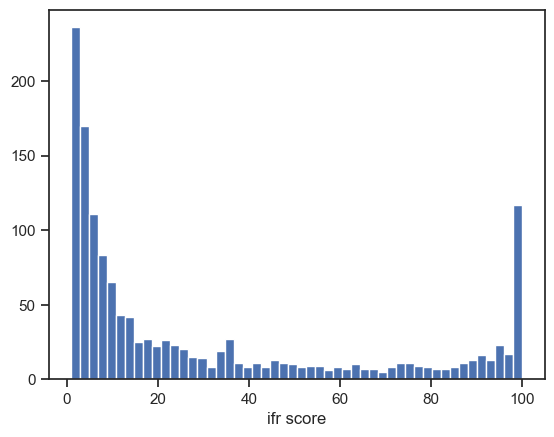

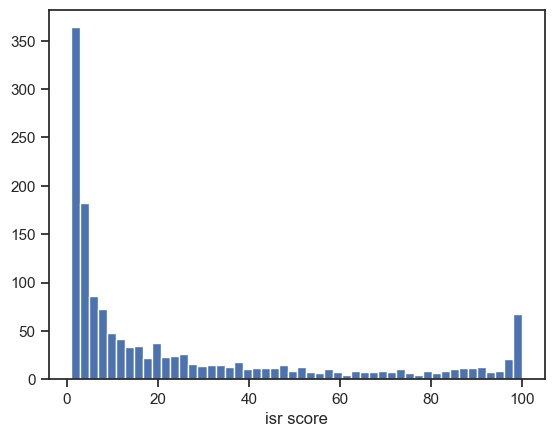

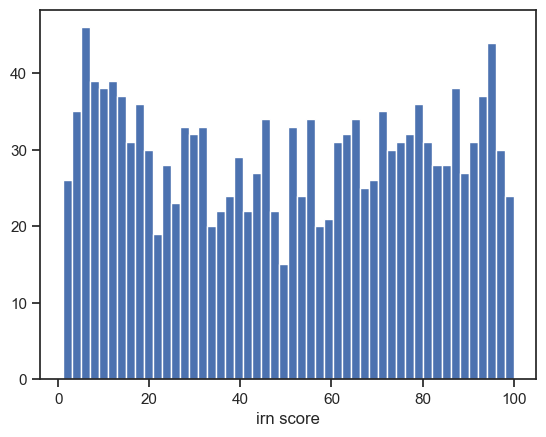

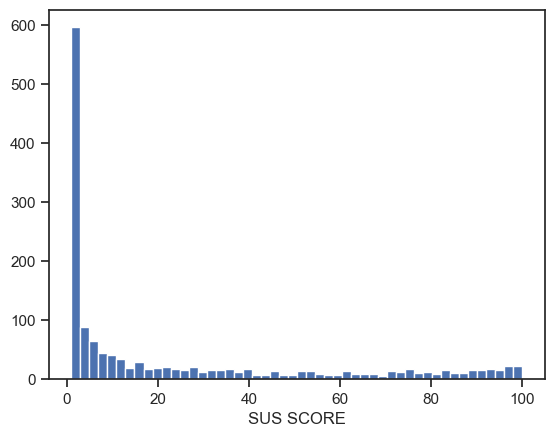

In [18]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

Будем использовать встроенные средства импьютации библиотеки scikit-learn - https://scikit-learn.org/stable/modules/impute.html

In [21]:
data_num_ifr_score = data_num[['ifr score']]
data_num_ifr_score.head()

,ifr score
0,99.3
1,100.0
2,98.1
3,74.1
4,100.0


In [22]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [23]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_ifr_score)
mask_missing_values_only

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

С помощью класса [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) можно проводить импьютацию различными [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)

In [24]:
strategies=['mean', 'median', 'most_frequent']

In [25]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_ifr_score)
    return data_num_imp[mask_missing_values_only]

In [26]:
strategies[0], test_num_impute(strategies[0])

('mean',
 array([30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670706, 30.73670706, 30.73670706,
        30.73670706, 30.73670706, 30.73670

In [27]:
strategies[1], test_num_impute(strategies[1])

('median',
 array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
        12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
        12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
        12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
        12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
        12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
        12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
        12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
        12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
        12.5]))

In [28]:
strategies[2], test_num_impute(strategies[2])

('most_frequent',
 array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100.]))

In [29]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [30]:
data[['irn score']].describe()

,irn score
count,1502.000000
mean,50.129095
std,29.866588
min,1.000000
25%,22.725000
50%,51.100000
75%,77.100000
max,100.000000


In [31]:
test_num_impute_col(data, 'irn score', strategies[0])

('irn score', 'mean', 1, 50.12909454061251, 50.12909454061251)

In [32]:
test_num_impute_col(data, 'irn score', strategies[1])

('irn score', 'median', 1, 51.1, 51.1)

In [33]:
test_num_impute_col(data, 'irn score', strategies[2])

('irn score', 'most_frequent', 1, 13.1, 13.1)

### Обработка пропусков в категориальных данных

In [58]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in ['status', 'research', 'location', 'focus', 'size', 'location code']:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    cat_cols.append(col)
    temp_perc = round((temp_null_count / total_count) * 100.0, 2)
    print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка status. Тип данных object. Количество пустых значений 37, 2.46%.
Колонка research. Тип данных object. Количество пустых значений 0, 0.0%.
Колонка location. Тип данных object. Количество пустых значений 0, 0.0%.
Колонка focus. Тип данных object. Количество пустых значений 0, 0.0%.
Колонка size. Тип данных object. Количество пустых значений 0, 0.0%.
Колонка location code. Тип данных object. Количество пустых значений 0, 0.0%.


**Какие из этих колонок Вы бы выбрали или не выбрали для построения модели?**

Для построения модели я бы выбрал status, location code, focus. Остальные - либо не вносят принципиально новой информации, либо избыточны.
Класс SimpleImputer можно использовать для категориальных признаков со стратегией "mean" и "most frequent".

In [59]:
cat_temp_data = data[['status']]
cat_temp_data.head()

,status
0,B
1,A
2,A
3,B
4,A


In [60]:
cat_temp_data['status'].unique()

array(['B', 'A', 'C', nan], dtype=object)

In [61]:
cat_temp_data[cat_temp_data['status'].isnull()].shape

(37, 1)

In [62]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['B'],
       ['A'],
       ['A'],
       ...,
       ['C'],
       ['A'],
       ['A']], dtype=object)

In [63]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['A', 'B', 'C'], dtype=object)

In [64]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['B'],
       ['A'],
       ['A'],
       ...,
       ['C'],
       ['A'],
       ['NA']], dtype=object)

In [65]:
np.unique(data_imp3)

array(['A', 'B', 'C', 'NA'], dtype=object)

In [66]:
data_imp3[data_imp3=='NA'].size

37

# Преобразование категориальных признаков в числовые

In [67]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,B
1,A
2,A
3,B
4,A
...,...
1498,A
1499,A
1500,C
1501,A


## Кодирование категорий целочисленными значениями (label encoding)

В этом случае уникальные значения категориального признака кодируются целыми числами.

В scikit-learn для такого кодирования используется два класса :

- [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) - который ориентирован на применение к одному признаку. Этот класс прежде всего предназначен для кодирования целевого признака, но может быть также использован для последовательного кодирования отдельных нецелевых признаков.
- [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) - который ориентирован на применение к матрице объект-признак, то есть для кодирования матрицы нецелевых признаков.

### Использование LabelEncoder

In [68]:
from sklearn.preprocessing import LabelEncoder

In [69]:
cat_enc['c1'].unique()

array(['B', 'A', 'C'], dtype=object)

In [70]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [71]:
# Наименования категорий в соответствии с порядковыми номерами

# Свойство называется classes, потому что предполагается что мы решаем 
# задачу классификации и каждое значение категории соответствует 
# какому-либо классу целевого признака

le.classes_

array(['A', 'B', 'C'], dtype=object)

In [72]:
cat_enc_le

array([1, 0, 0, ..., 2, 0, 0])

In [73]:
np.unique(cat_enc_le)

array([0, 1, 2])

In [74]:
# В этом примере видно, что перед кодированием 
# уникальные значения признака сортируются в лексикографиеском порядке
le.inverse_transform([0, 1, 2])

array(['A', 'B', 'C'], dtype=object)

### Использование OrdinalEncoder

In [75]:
from sklearn.preprocessing import OrdinalEncoder

In [76]:
data_oe = data[['status', 'research', 'location', 'focus', 'size', 'location code']]
data_oe.head()

,status,research,location,focus,size,location code
0,B,VH,Americas,CO,M,United States
1,A,VH,Europe,FC,L,United Kingdom
2,A,VH,Europe,FC,L,United Kingdom
3,B,VH,Americas,FC,L,United States
4,A,VH,Europe,FC,L,United Kingdom


In [77]:
imp4 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_oe_filled = imp4.fit_transform(data_oe)
data_oe_filled

array([['B', 'VH', 'Americas', 'CO', 'M', 'United States'],
       ['A', 'VH', 'Europe', 'FC', 'L', 'United Kingdom'],
       ['A', 'VH', 'Europe', 'FC', 'L', 'United Kingdom'],
       ...,
       ['C', 'MD', 'Asia', 'CO', 'M', 'Philippines'],
       ['A', 'VH', 'Europe', 'FO', 'L', 'Romania'],
       ['NA', 'HI', 'Americas', 'CO', 'L', 'United States']], dtype=object)

In [78]:
oe = OrdinalEncoder()
cat_enc_oe = oe.fit_transform(data_oe_filled)
cat_enc_oe

array([[  1.,   3.,   1.,   0.,   1., 101.],
       [  0.,   3.,   3.,   1.,   0., 100.],
       [  0.,   3.,   3.,   1.,   0., 100.],
       ...,
       [  2.,   2.,   2.,   0.,   1.,  73.],
       [  0.,   3.,   3.,   2.,   0.,  78.],
       [  3.,   0.,   1.,   0.,   0., 101.]])

In [79]:
# Уникальные значения 1 признака
np.unique(cat_enc_oe[:, 0])

array([0., 1., 2., 3.])

In [80]:
# Уникальные значения 2 признака
np.unique(cat_enc_oe[:, 1])

array([0., 1., 2., 3.])

In [81]:
# Уникальные значения 3 признака
np.unique(cat_enc_oe[:, 2])

array([0., 1., 2., 3., 4., 5.])

In [82]:
# Наименования категорий в соответствии с порядковыми номерами
oe.categories_

[array(['A', 'B', 'C', 'NA'], dtype=object),
 array(['HI', 'LO', 'MD', 'VH'], dtype=object),
 array(['Africa', 'Americas', 'Asia', 'Europe', 'Not Classified',
        'Oceania'], dtype=object),
 array(['CO', 'FC', 'FO', 'SP'], dtype=object),
 array(['L', 'M', 'S', 'XL'], dtype=object),
 array(['Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
        'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia',
        'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria', 'Canada',
        'Chile', 'China (Mainland)', 'Colombia', 'Costa Rica', 'Croatia',
        'Cuba', 'Cyprus', 'Czech Republic', 'Denmark',
        'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Ethiopia',
        'Finland', 'France', 'Georgia', 'Germany', 'Ghana', 'Greece',
        'Guatemala', 'Honduras', 'Hong Kong SAR', 'Hungary', 'Iceland',
        'India', 'Indonesia', 'Iran, Islamic Republic of', 'Iraq',
        'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan',
        'Kenya', 'K

In [83]:
# Обратное преобразование
oe.inverse_transform(cat_enc_oe)

array([['B', 'VH', 'Americas', 'CO', 'M', 'United States'],
       ['A', 'VH', 'Europe', 'FC', 'L', 'United Kingdom'],
       ['A', 'VH', 'Europe', 'FC', 'L', 'United Kingdom'],
       ...,
       ['C', 'MD', 'Asia', 'CO', 'M', 'Philippines'],
       ['A', 'VH', 'Europe', 'FO', 'L', 'Romania'],
       ['NA', 'HI', 'Americas', 'CO', 'L', 'United States']], dtype=object)

### Проблемы использования LabelEncoder и OrdinalEncoder

Необходимо отметить, что LabelEncoder и OrdinalEncoder могут использоваться только для категориальных признаков в номинальных шкалах (для которых отсутствует порядок), например города, страны, названия рек и т.д. 

Это связано с тем, что задать какой-либо порядок при кодировании с помощью LabelEncoder и OrdinalEncoder невозможно, они сортируют категории в лексикографическом порядке.

При этом кодирование целыми числами создает фиктивное отношение порядка (1 < 2 < 3 < ...) которого не было в исходных номинальных шкалах. Данное отношение порядка может негативно повлиять на построение модели машинного обучения.

### Кодирование шкал порядка

Библиотека scikit-learn не предоставляет готового решения для кодирования шкал порядка, но можно воспользоваться [функцией map для отдельных объектов Series.](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)

In [84]:
# пример шкалы порядка 'small' < 'medium' < 'large'
sizes = ['small', 'medium', 'large', 'small', 'medium', 'large', 'small', 'medium', 'large']

In [85]:
pd_sizes = pd.DataFrame(data={'sizes':sizes})
pd_sizes

,sizes
0,small
1,medium
2,large
3,small
4,medium
5,large
6,small
7,medium
8,large


In [86]:
pd_sizes['sizes_codes'] = pd_sizes['sizes'].map({'small':1, 'medium':2, 'large':3})
pd_sizes

,sizes,sizes_codes
0,small,1
1,medium,2
2,large,3
3,small,1
4,medium,2
5,large,3
6,small,1
7,medium,2
8,large,3


In [87]:
pd_sizes['sizes_decoded'] = pd_sizes['sizes_codes'].map({1:'small', 2:'medium', 3:'large'})
pd_sizes

,sizes,sizes_codes,sizes_decoded
0,small,1,small
1,medium,2,medium
2,large,3,large
3,small,1,small
4,medium,2,medium
5,large,3,large
6,small,1,small
7,medium,2,medium
8,large,3,large


## Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

В этом случае каждое уникальное значение признака становится новым отдельным признаком.

In [88]:
from sklearn.preprocessing import OneHotEncoder

In [89]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [90]:
cat_enc.shape

(1503, 1)

In [91]:
cat_enc_ohe.shape

(1503, 3)

In [92]:
cat_enc_ohe

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1503 stored elements and shape (1503, 3)>

In [93]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])

In [94]:
cat_enc.head(10)

,c1
0,B
1,A
2,A
3,B
4,A
5,B
6,A
7,A
8,A
9,B


## [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

In [95]:
pd.get_dummies(cat_enc).head()

,c1_A,c1_B,c1_C
0,False,True,False
1,True,False,False
2,True,False,False
3,False,True,False
4,True,False,False


In [96]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,status_A,status_B,status_C,status_nan
0,False,True,False,False
1,True,False,False,False
2,True,False,False,False
3,False,True,False,False
4,True,False,False,False


# Масштабирование данных

Термины "масштабирование" и "нормализация" часто используются как синонимы, но это неверно. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины. В этом разделе рассматривается только масштабирование.

Если признаки лежат в различных диапазонах, то необходимо их нормализовать. Как правило, применяют два подхода:
- MinMax масштабирование:
$$ x_{новый} = \frac{x_{старый} - min(X)}{max(X)-min(X)} $$

В этом случае значения лежат в диапазоне от 0 до 1.
- Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0):
$$ x_{новый} = \frac{x_{старый} - AVG(X) }{\sigma(X)} $$

В этом случае большинство значений попадает в диапазон от -3 до 3.

где $X$ - матрица объект-признак, $AVG(X)$ - среднее значение, $\sigma$ - среднеквадратичное отклонение.

In [97]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [103]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['SUS SCORE']])

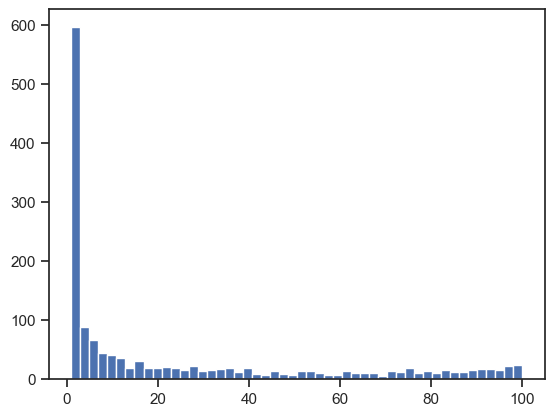

In [106]:
plt.hist(data['SUS SCORE'], 50)
plt.show()

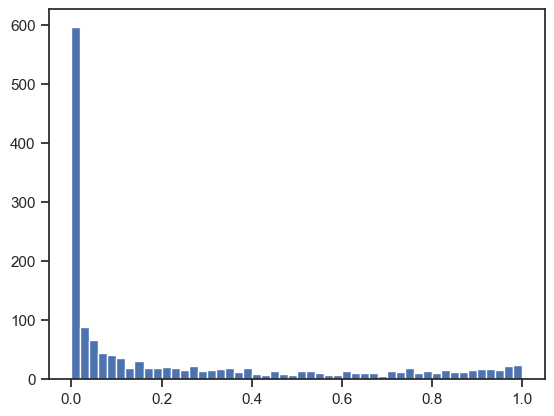

In [107]:
plt.hist(sc1_data, 50)
plt.show()

## Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0) - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [108]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['fsr score']])

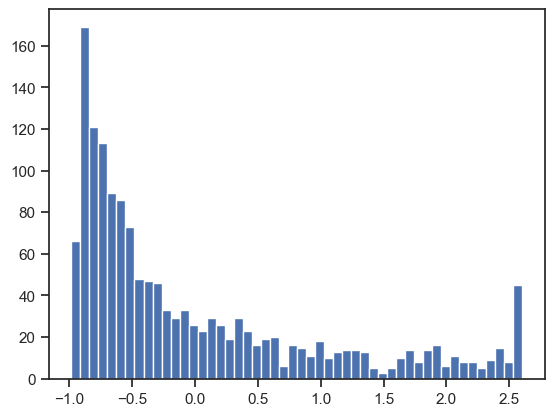

In [109]:
plt.hist(sc2_data, 50)
plt.show()

# Дополнительные источники
- [Руководство scikit-learn по предобработке данных](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Kaggle Data Cleaning Challenge: Handling missing values (упражнения с пояснениями по обработке пропущенных значений и масштабированию признаков)](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values)
- [Краткое руководство по категориальным признакам](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c)